<a href="https://colab.research.google.com/github/fact-h/Graduation-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 复现论文
目标：根据降雨序列预测最大水深，每次降雨的序列分为10个特征，最大水深作为标签

## 导入相关的模块

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## 数据预处理
### 加载数据集
先上传CSV数据文件，再创建两个DataFrames：
- **`train_df`** 包含训练集
- **`test_df`** 包含测试集

In [57]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [66]:
train_df = pd.read_csv('/content/train.csv')
train_df = train_df.reindex(np.random.permutation(train_df.index)) # 打乱数据
test_df = pd.read_csv('/content/test.csv')

In [67]:
train_df.head()

,rain1,rain2,rain3,rain4,rain5,rain6,rain7,rain8,rain9,rain10,depth
13,0.095,0.095,0.095,0.095,5.040,3.233,7.607,16.165,34.612,28.051,0.209
10,3.423,21.300,11.506,4.564,5.705,4.564,5.705,14.739,9.033,14.548,0.294
3,0.076,0.076,0.076,0.076,4.048,2.597,6.109,12.983,27.798,22.529,0.158
31,0.469,3.282,5.470,25.475,41.730,13.754,13.441,21.412,20.005,11.253,0.324
25,5.117,31.837,17.197,6.822,8.528,6.822,8.528,22.030,13.502,21.746,0.317


In [68]:
test_df.head()

,rain1,rain2,rain3,rain4,rain5,rain6,rain7,rain8,rain9,rain10,depth
0,2.545,15.836,8.555,3.394,4.242,3.394,4.242,10.958,6.717,10.817,0.27
1,2.545,15.836,8.555,3.394,4.242,3.394,4.242,10.958,6.717,10.817,0.27
2,2.545,15.836,8.555,3.394,4.242,3.394,4.242,10.958,6.717,10.817,0.27


### 归一化
当建立的模型有多个特征时，每个特征的值应该大致在相同范围。

In [78]:
# 计算训练集每个特征(列)的Z-scores
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# 计算测试集每个特征(列)的Z-scores
test_df_norm = (test_df - train_df_mean)/train_df_std

print("Normalized the values.")

Normalized the values.


In [80]:
train_df_norm.head()

,rain1,rain2,rain3,rain4,rain5,rain6,rain7,rain8,rain9,rain10,depth
13,-0.807000,-0.656299,-1.006945,-0.791458,-0.633365,-1.345765,-0.337043,0.080626,0.678383,0.970423,-1.643730
10,0.790026,1.457196,1.071760,-0.566078,-0.570714,-0.891327,-1.036100,-0.126043,-0.774774,-0.198988,0.360408
3,-0.816117,-0.658193,-1.010407,-0.792416,-0.726823,-1.562912,-0.887615,-0.380538,0.291276,0.492197,-2.846213
31,-0.627526,-0.338652,-0.027799,0.488504,2.823268,2.246378,1.807174,0.841069,-0.151449,-0.484348,1.067751
25,1.602935,2.507414,2.108472,-0.452203,-0.304754,-0.120387,0.001460,0.930635,-0.520888,0.424386,0.902704


In [81]:
test_df_norm.head()

,rain1,rain2,rain3,rain4,rain5,rain6,rain7,rain8,rain9,rain10,depth
0,0.368695,0.912601,0.534186,-0.625083,-0.708546,-1.290795,-1.573808,-0.67402,-0.906348,-0.522107,-0.205466
1,0.368695,0.912601,0.534186,-0.625083,-0.708546,-1.290795,-1.573808,-0.67402,-0.906348,-0.522107,-0.205466
2,0.368695,0.912601,0.534186,-0.625083,-0.708546,-1.290795,-1.573808,-0.67402,-0.906348,-0.522107,-0.205466


## 表示数据
下面的代码创建一个特征层，包括10个特征：从`rain1`到`rain10`。

确定训练模型要用的特征以及这些特征的表示方式。`my_feature_layer`在训练模型时才会用到。

In [70]:
# 创建一个空的列表，用来放所有特征列
feature_columns = []

# 将各降雨值表示为浮点数值
rain1 = tf.feature_column.numeric_column("rain1")
feature_columns.append(rain1)

rain2 = tf.feature_column.numeric_column("rain2")
feature_columns.append(rain2)

rain3 = tf.feature_column.numeric_column("rain3")
feature_columns.append(rain3)

rain4 = tf.feature_column.numeric_column("rain4")
feature_columns.append(rain4)

rain5 = tf.feature_column.numeric_column("rain5")
feature_columns.append(rain5)

rain6 = tf.feature_column.numeric_column("rain6")
feature_columns.append(rain6)

rain7 = tf.feature_column.numeric_column("rain7")
feature_columns.append(rain7)

rain8 = tf.feature_column.numeric_column("rain8")
feature_columns.append(rain8)

rain9 = tf.feature_column.numeric_column("rain9")
feature_columns.append(rain9)

rain10 = tf.feature_column.numeric_column("rain10")
feature_columns.append(rain10)

# 将特征列的列表转化为一个层，稍后添加到模型中
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## 定义绘图函数

In [71]:
def plot_the_loss_curve(epochs, mse):
  # 绘制loss vs. epoch的曲线图
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max()*1.03])
  plt.show()

print("定义plot_the_loss_curve函数")  

定义plot_the_loss_curve函数


## 定义一个深度神经网络模型
`create_model`函数定义了神经网络的拓扑结构：
- 深度神经网络的层数
- 每一层的节点数

`create_model`还定义了每一层的激活函数

In [97]:
def create_model(my_learning_rate, my_feature_layer):
  # 创建并配置模型
  # 使用sequential创建模型
  model = tf.keras.models.Sequential()

  # 添加一个包含特征列的层到模型，也就是输入层
  model.add(my_feature_layer)

  # 对于每一层，使用 tf.keras.layers.Dense 方法描述模型的拓扑结构
  # 确定以下参数：
  #     * units 指定该层的节点数量
  #     * activation 指定激活函数（Rectified Linear Unit a.k.a. ReLU）
  #     * name 在debug的时候有用

  # 定义第一个隐藏层，包含20个节点
  model.add(tf.keras.layers.Dense(
      units=20,
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), # 加入正则项，防止模型过于复杂出现过拟合现象
      name='Hidden1'))
  
  # 添加一个dropout层，dropout可随机使一定比例的输入节点失效，即变为0
  # 可防止过拟合
  # model.add(tf.keras.layers.Dropout(rate=0.1)) 

  # 定义第二个隐藏层，包含12个节点
  model.add(tf.keras.layers.Dense(
      units=12,
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
      name='Hidden2'))
  
  # 添加一个dropout层，dropout可随机使一定比例的输入节点失效，即变为0
  # 可防止过拟合
  # model.add(tf.keras.layers.Dropout(rate=0.1)) 

  # 定义输出层
  model.add(tf.keras.layers.Dense(units=1,name='Output'))

  # 配置模型
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
  
  return model

## 定义训练函数
定义的`train_model`函数从输入的特征和标签训练模型，使用`tf.keras.Model.fit`方法训练模型，该方法的参数`x`非常灵活，支持多种方式传入特征数据，下面使用Python的字典输入数据：
- *keys*是每个特征的名字（例如，`rain1`,`rain2`等）
- 每个键的值是包含该特征的值的NumPy序列


In [87]:
def train_model(model, dataset, epochs, label_name, batch_size=None, my_validation_split=0.2):
  # 将数据集分为特征和标签
  # 特征存储为字典类型
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))

  # 训练模型，并将结果存储在history
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=my_validation_split)
  # epochs列表从history剩余部分分开存储
  epochs = history.epoch

  # 为追踪训练进展，得到每个epoch的模型均方差
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse


## 调用函数建立并训练深度神经网络
可修改三个超参数查看测试集的损失函数是否减小

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 1.7460 - mean_squared_error: 1.4607 - val_loss: 1.2842 - val_mean_squared_error: 1.0034
Epoch 2/30
1/1 [==============================] - 0s 50ms/step - loss: 1.3396 - mean_squared_error: 1.0587 - val_loss: 1.0258 - val_mean_squared_error: 0.7492
Epoch 3/30
1/1 [==============================] - 0s 71ms/step - loss: 1.0594 - mean_squared_error: 0.7828 - val_loss: 0.8328 - val_mean_squared_error: 0.5599
Epoch 4/30
1/1 [==============================] - 0s 43ms/step - loss: 0.8538 - mean_squared_error: 0.5808 - val_loss: 0.6832 - val_mean_squared_error: 0.4135
Epoch 5/30
1/1 [==============================] - 0s 43ms/step - loss: 0.6951 - mean_squared_error: 0.4254 - val_loss: 0.5715 - val_mean_squared_error: 0.3045
Epoch 6/30
1/1 [==============================] - 0s 50ms/step - loss: 0.5769 - mean_squared_error: 0.3099 - val_loss: 0.4977 - val_mean_squared_error: 0.2330
Epoch 7/30
1/1 [==============================] - 0s 62ms/s

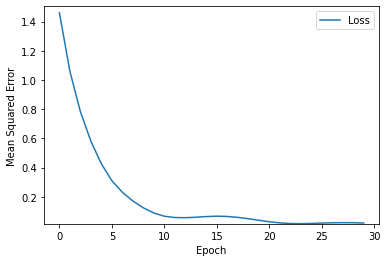


 使用测试集评估模型：
1/1 [==============================] - 0s 34ms/step - loss: 0.2007 - mean_squared_error: 0.0014


[0.2006930559873581, 0.0014156674733385444]

In [109]:
# 下面的变量是超参数
learning_rate = 0.01
epochs = 30
batch_size = None

# 将原始的训练集分为一个较小的训练集和一个验证集
validation_split = 0.2

# 指定标签，即水深
label_name = "depth"

# 构建模型拓扑结构，输入学习率和特征层
my_model = create_model(learning_rate, my_feature_layer)

# 使用归一化后的训练集训练模型，模型使用feature_layer定义的特征，此处全部使用
epochs, mse = train_model(my_model, train_df_norm, epochs,
                          label_name, batch_size,
                          validation_split)
plot_the_loss_curve(epochs, mse)

# 使用训练集建立模型后，使用测试集测试模型
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # 分离标签
print("\n 使用测试集评估模型：")
my_model.evaluate(x=test_features, y=test_label)

In [104]:
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

1/1 [==============================] - 0s 34ms/step - loss: 0.1817 - mean_squared_error: 0.0418


[0.18168437480926514, 0.04181666672229767]

In [115]:
print(my_model.predict(test_features) * train_df_std[-1] + train_df_mean[-1])

[[0.26840425]
 [0.26840425]
 [0.26840425]]


In [114]:
print(train_df_std[-1])

0.04241224256423764
